In [6]:
using PyCall
using PyPlot
using FFTW
using LinearAlgebra
using JLD2
using YAML
# FFTW.set_num_threads(16)

@pyimport mpl_toolkits.axes_grid1 as axgrid
plt.style.use("dark_background")
# plt.style.use("default")
plt.rc("font", family="STIXGeneral")
plt.rc("font", size=22)
plt.rc("mathtext", fontset="stix")

mpl = pyimport("matplotlib")
np = pyimport("numpy")

config = YAML.load_file("../config.yaml")

Dict{Any, Any} with 16 entries:
  "DM_particle_mass_Dark" => 0.00472716
  "run_name"              => "density_cube_snap_099_full_1024_all_species"
  "xmin"                  => 0.0
  "num_scales"            => 10
  "GAS_particle_mass_TNG" => 0.000743736
  "output_directory"      => "/global/cscratch1/sd/james12/NEXUS_analysis/Full_…
  "nx"                    => 1024
  "N_GAS"                 => 15625000000
  "num_snaps"             => 1
  "snapfile_root"         => 99
  "algorithm"             => "NEXUS+"
  "input_directory"       => "/global/cscratch1/sd/james12/Illustris_TNG_Data/T…
  "simulation_type"       => "All"
  "DM_particle_mass_TNG"  => 0.00398343
  "N_DM"                  => 15625000000
  "xmax"                  => 205000.0

# Let's Load in the Maximum Signatures

We load in maximum signatures from the NEXUS algorithm run of the Dark Matter only simulation with resolution $1024^3$

In [2]:
@load config["output_directory"] *"Full_Species_1024_snap_099/"* "max_sigs_" * config["run_name"] * "_NEXUSPLUS" * "_full_signatures.jld2" sigmax

1-element Vector{Symbol}:
 :sigmax

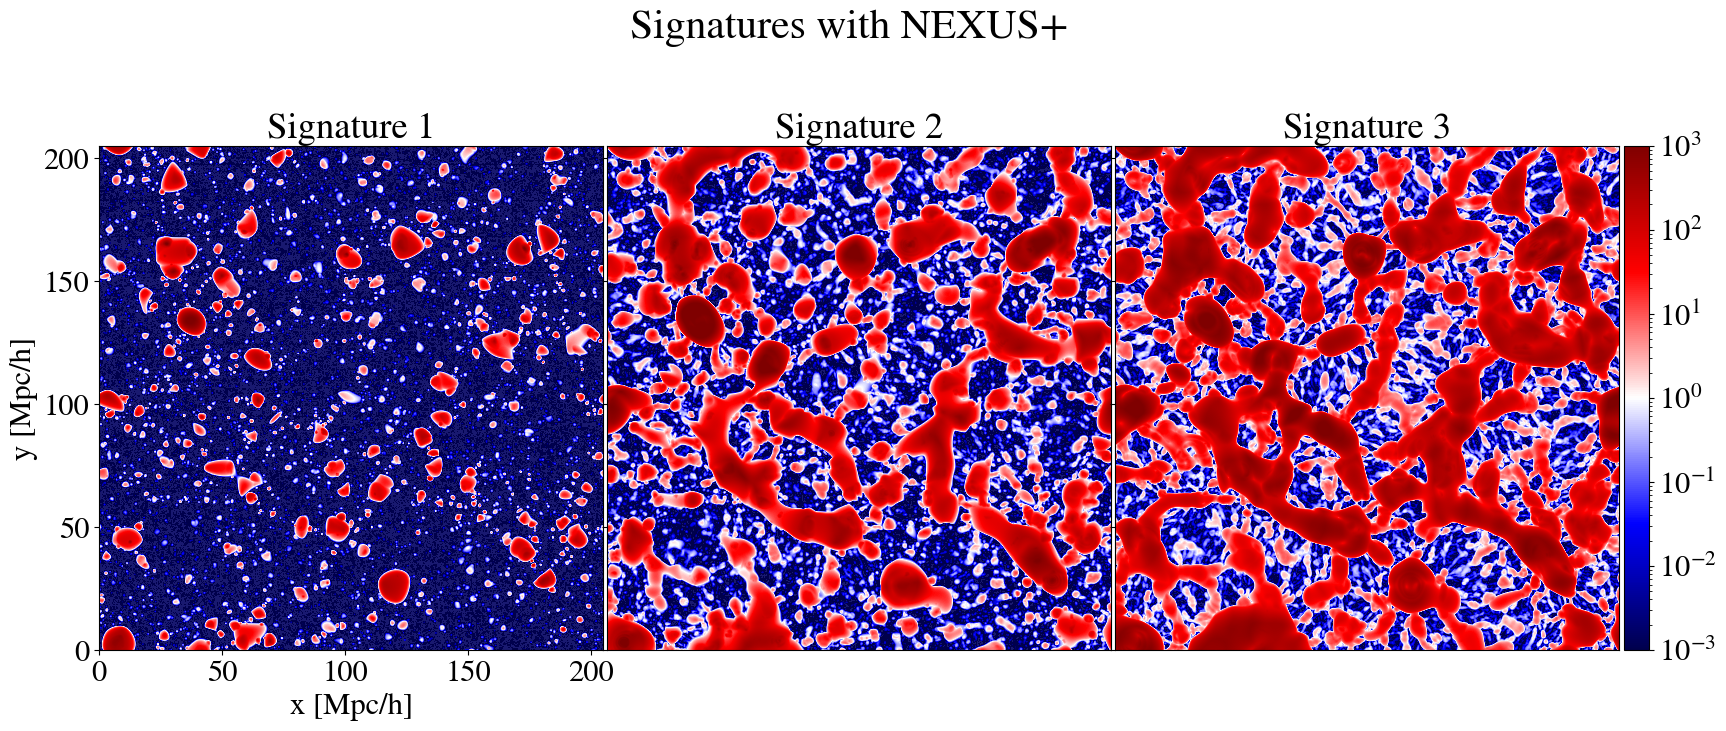

In [4]:

# plt.style.use("light_mode")
plt.style.use("default")
plt.rc("font", family="STIXGeneral")
plt.rc("font", size=22)
plt.rc("mathtext", fontset="stix")
plt.rc("axes", facecolor="midnightblue")

cmap_ = "seismic"

f, axes = plt.subplots(1,3,sharey=true, gridspec_kw = Dict("wspace" => -0.05, "hspace" => 0), figsize=(20,8))

f.suptitle("Signatures with NEXUS+", fontsize=30)

axes[1].set_title("Signature 1")
im1 = axes[1].imshow(sigmax[:,:,200,1], origin="lower", cmap=cmap_, 
    extent=(0,config["xmax"]/1000,0,config["xmax"]/1000), norm=mpl.colors.LogNorm(vmin=0.001, vmax=1000.0))

divider1 = axgrid.make_axes_locatable(axes[1])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cax1.set_axis_off()

axes[2].set_title("Signature 2")
im2 = axes[2].imshow(sigmax[:,:,200,2], origin="lower", cmap=cmap_, 
    extent=(0,config["xmax"]/1000,0,config["xmax"]/1000), norm=mpl.colors.LogNorm(vmin=0.001, vmax=1000.0))
divider2 = axgrid.make_axes_locatable(axes[2])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cax2.set_axis_off()

axes[3].set_title("Signature 3")
im3 = axes[3].imshow(sigmax[:,:,200,3], origin="lower", cmap=cmap_, 
    extent=(0,config["xmax"]/1000,0,config["xmax"]/1000), norm=mpl.colors.LogNorm(vmin=0.001, vmax=1000.0))
divider3 = axgrid.make_axes_locatable(axes[3])
cax3 = divider3.append_axes("right", size="5%", pad=0.05)

for ax in axes
    ax.set_aspect("equal")
    if ax == axes[1]
        ax.set_xlabel("x [Mpc/h]")
        ax.set_ylabel("y [Mpc/h]")
    else
        ax.set_xticks([])
        # ax.set_yticks([])
    end
end

plt.colorbar(im3, cax=cax3)
f.tight_layout()
plt.savefig("../../../../Images/NEXUSPLUS_sigs_1024_Full_Species_only_lightmode.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

# Let's Determine Structure Types using Tagging

In [50]:
#reduce size of sigmax for example
sigmax = sigmax[1:512, 1:512, 1:512, :]

In [9]:
#load in data and reduce size for example
@load config["input_directory"] * config["run_name"] * ".jld2" den

1-element Vector{Symbol}:
 :den

### Import CosmoMMF

In [56]:
using CosmoMMF

In [ ]:
@time clusbool, filbool, wallbool, S_fil, dM2_fil, S_wall, dM2_wall = CosmoMMF.calc_structure_bools(mass_of_average_cell, 240.0, 
                                                                                                    sigmax_NEXUS, sigmax_NEXUSPLUS, den)

print("Generating Different Structure Boolean Filters")

## Plot Results!

In [7]:
@load config["output_directory"] * config["run_name"] * "_cluster_bool_filter.jld2" clusbool
@load config["output_directory"] * config["run_name"] * "_filament_bool_filter.jld2" filbool
@load config["output_directory"] * config["run_name"] * "_wall_bool_filter.jld2" wallbool

1-element Vector{Symbol}:
 :wallbool

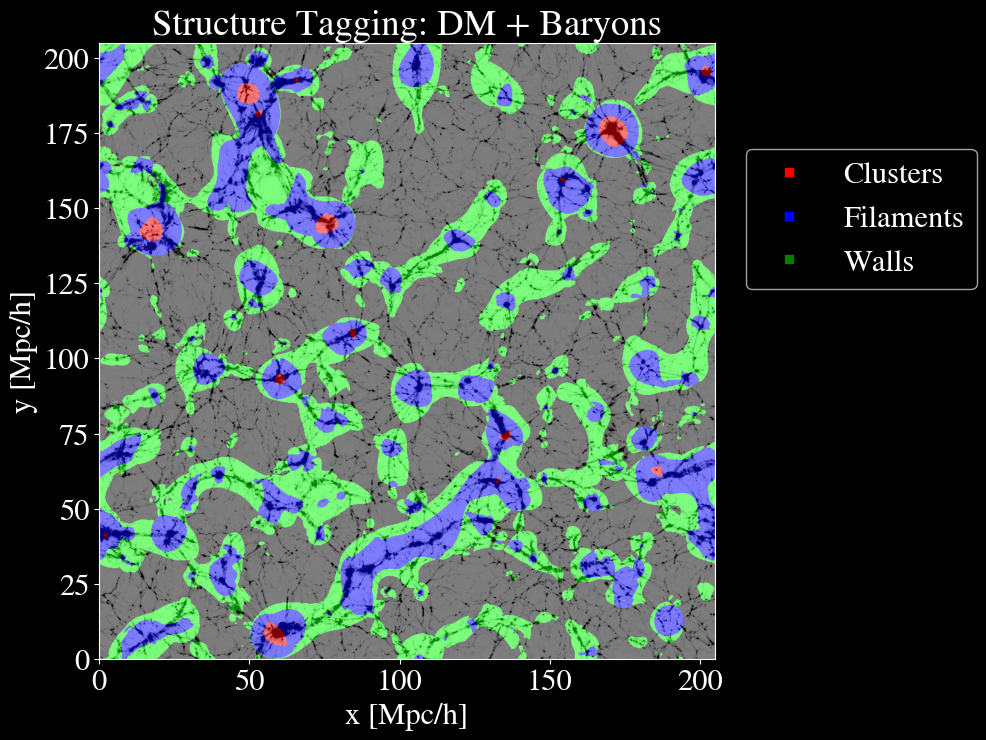

In [23]:
plt.style.use("dark_background")
# plt.style.use("default")
plt.rc("font", family="STIXGeneral")
plt.rc("font", size=22)
plt.rc("mathtext", fontset="stix")

fig, ax = subplots(1,1,figsize=(14,8))

slice = 512
densq = -clamp.(den[:,:,slice], 0, 3)/3 .+ 1 # density plot
densq ./= 2
ax.set_title("Structure Tagging: DM + Baryons")
ax.set_xlabel("x [Mpc/h]")
ax.set_ylabel("y [Mpc/h]")

ax.imshow(  cat( [
            transpose(clamp.(densq + (clusbool[:,:,slice])[:,:,1] / 2, 0.0,1.0)), 
            transpose(clamp.(densq + wallbool[:,:,slice] / 2, 0.0, 1.0)),
            transpose(clamp.(densq + filbool[:,:,slice] / 2, 0.0, 1.0))]..., dims=3) , origin="lower",extent=(0,config["xmax"]/1000,0,config["xmax"]/1000))

plt.axvline()

plt.plot([],[],"rs", label="Clusters")
plt.plot([],[], "bs", label="Filaments")
plt.plot([],[], "gs", label="Walls")
plt.legend(loc=(1.05,0.6))
plt.savefig("../../../../Images/NEXUSPLUS_Full_Species_all_components_darkmode.png", format="png", dpi=300, bbox_inches="tight")
plt.show()